# Self Health Study

This study will help me learn how food and excercise are affecting my weight and overall well-being. I am using historical data (unfortenately not continuous) exported from myfitnesspal. It covers a period of 6 years of "struggling".

First I will read the data I have into a pandas dataframe

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

exercise = pd.read_csv('myfitnesspal/Exercise-Summary.csv', index_col = 0)
measurement = pd.read_csv('myfitnesspal/Measurement-Summary.csv', index_col = 0)
nutrition = pd.read_csv('myfitnesspal/Nutrition-Summary.csv', index_col = 0)

Before I start manipulating my data I want to check the exact time period which I need to use in order to sync my dataframes. You will see why I am doing this later.

In [253]:
exercise.index = pd.to_datetime(exercise.index)
measurement.index = pd.to_datetime(measurement.index)
nutrition.index = pd.to_datetime(nutrition.index)

print("Exercise Period :  ", exercise.index[0] , ' - ', exercise.index[-1])
print("Measurement Period :  ", measurement.index[0] , ' - ', measurement.index[-1])
print("Nutrition Period :  ", nutrition.index[0] , ' - ', nutrition.index[-1])

print("Overall Period: ", min(exercise.index[0],measurement.index[0],nutrition.index[0]), ' - ',
                          max(exercise.index[-1],measurement.index[-1],nutrition.index[-1]))

startDate = min(exercise.index[0],measurement.index[0],nutrition.index[0])
endDate = max(exercise.index[-1],measurement.index[-1],nutrition.index[-1])

Exercise Period :   2012-11-10 00:00:00  -  2018-01-25 00:00:00
Measurement Period :   2012-11-10 00:00:00  -  2018-01-24 00:00:00
Nutrition Period :   2012-11-11 00:00:00  -  2018-01-25 00:00:00
Overall Period:  2012-11-10 00:00:00  -  2018-01-25 00:00:00


## Data Engineering for the Excercise Dataframe
Showing the structure of the excersice dataframe

In [254]:
exercise.head()

,Exercise,Type,Exercise Calories,Exercise Minutes,Sets,Reps Per Set,Kilograms,Steps
Date,,,,,,,,
2012-11-10,Dips,Strength,NaN,NaN,7.0,10.0,36.3,NaN
2012-11-10,"Rowing, stationary, very vigorous effort",Cardio,227.0,22.0,NaN,NaN,NaN,NaN
2012-11-10,"Step-ups, vigorous",Cardio,251.0,20.0,NaN,NaN,NaN,NaN
2012-11-11,Chin-Ups,Strength,NaN,NaN,3.0,8.0,36.3,NaN
2012-11-11,Dips,Strength,NaN,NaN,5.0,10.0,36.3,NaN


The first thing which I don't like about this data is the presence of NaN values in my columns. I want to replace this with 0s so I can actually make calculations and etc.

I know that I haven't filled the variables Sets, Reps Per Set and Kilograms consistently thus there is no point keeping them for our analysis. On the other hand you can see that the dataframe have multiple rows with the same index (3 entries for the same date) my aim is to simply aggregate this data to a single value and have only one entry per day which can describe all the data in the original table.

In order to accomplish the data aggregation I will add some categorical variables to my excercise dataframe **Strength Training  - [yes/no]**


It will not be much fun to try to aggregate the dataframe in place so I will simply make a new dataframe and transfer the aggregated information into it. Another reason why I don't want to do it in place is that my index values (the dates) are not continuous, for example some of the days I haven't logged any activity. In the end I want to perform a time-series analysis of this data and I would prefer not to have "holes" in the time-series. Thus I will add all missing days and simply give them value of 0.

In [255]:
exercise.fillna(value=0, inplace=True)

exercise_agg = pd.DataFrame(-1, columns=['Calories Burned', 
                                        'Cardio Minutes', 
                                        'Strength Training'
                                       ], index=pd.date_range(start=startDate, end=endDate ,freq='D'))

exercise_agg['Calories Burned'] = exercise.groupby('Date')['Exercise Calories'].sum()
exercise_agg['Cardio Minutes'] = exercise.groupby('Date')['Exercise Minutes'].sum()
exercise_agg['Strength Training'] = exercise.groupby('Date')['Exercise Calories'].min()
exercise_agg['Steps'] = exercise.groupby('Date')['Steps'].sum()
exercise_agg.fillna(value=0, inplace=True)


def boolStrength(x):
    if x == 0.0:
        return 'yes'
    else:
        return 'no'

exercise_agg['Strength Training'] = exercise_agg['Strength Training'].apply(lambda x: boolStrength(x))

And finally we got our data in the following form:

In [256]:
exercise_agg.head()

,Calories Burned,Cardio Minutes,Strength Training,Steps
2012-11-10,478.0,42.0,yes,0.0
2012-11-11,577.0,55.0,yes,0.0
2012-11-12,482.0,55.0,no,0.0
2012-11-13,441.0,40.0,yes,0.0
2012-11-14,0.0,0.0,yes,0.0


## Data Engineering for the Measurement Dataframe
Showing the structure of the measurement dataframe

In [257]:
measurement.head()

,Hips,Neck,Waist,Weight
Date,,,,
2012-11-10,NaN,NaN,NaN,113.8
2012-11-11,NaN,NaN,NaN,114.1
2012-11-13,NaN,NaN,NaN,113.5
2012-11-18,NaN,NaN,NaN,113.9
2012-11-24,NaN,NaN,NaN,114.2


I know that my measurments for hips, neck and waist are total garbage as I measured them only once and it wasn't even a proper measurment, thus I will simply remove them from the dataframe. Next thing which I will do is to extend the time-series of measurements and add all missing days. Now the question is what will I fill for weight for the days where I actually didn't measure it. Well I will use linear interpolation to fill in all the gaps.

In [258]:
measurement.drop(['Hips','Neck','Waist'], axis=1, inplace=True)

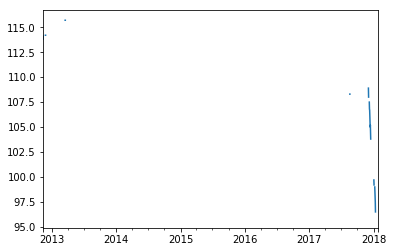

In [259]:
measurement_agg = pd.DataFrame(-1, columns=['Weight', 
                                            'dW',
                                            'Age',
                                            'BMI',
                                            'Height'
                                           ], index=pd.date_range(start=startDate, end=endDate ,freq='D'))

measurement_agg['Weight'] = measurement.groupby('Date')['Weight'].mean()
measurement_agg['Weight'].plot.line()

Look at the gaps in weight measrements above. Let's fix this

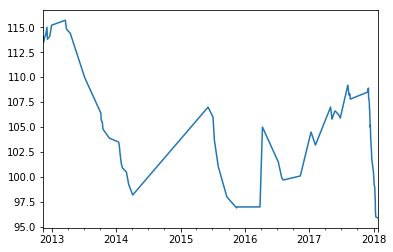

In [260]:
measurement_agg['Weight'].interpolate(inplace=True)
measurement_agg['Weight'].plot.line()

In [261]:
measurement_agg.head()

,Weight,dW,Age,BMI,Height
2012-11-10,113.80,-1,-1,-1,-1
2012-11-11,114.10,-1,-1,-1,-1
2012-11-12,113.80,-1,-1,-1,-1
2012-11-13,113.50,-1,-1,-1,-1
2012-11-14,113.58,-1,-1,-1,-1


Now let's fill in the data in the rest of the columns:

In [262]:
measurement_agg['Height'] = 1.76  #constant durting the entire period
measurement_agg['BMI'] = np.round(measurement_agg['Weight'] / measurement_agg['Height']**2,2)
measurement_agg['Age'] = np.round((measurement_agg.index - pd.Timestamp('1988-06-07')) / pd.Timedelta(days=365),1)
measurement_agg['dW'] = measurement_agg['Weight'].diff(periods=1)
measurement_agg.at[measurement_agg.index[0],'dW'] = 0

measurement_agg.fillna(value=0, inplace=True)
measurement_agg.head()

,Weight,dW,Age,BMI,Height
2012-11-10,113.80,0.00,24.4,36.74,1.76
2012-11-11,114.10,0.30,24.4,36.83,1.76
2012-11-12,113.80,-0.30,24.4,36.74,1.76
2012-11-13,113.50,-0.30,24.5,36.64,1.76
2012-11-14,113.58,0.08,24.5,36.67,1.76


## Data Engineering for the Nutrition Dataframe
Showing the structure of the nutrition dataframe

In [263]:
nutrition.head()

,Meal,Calories,Fat (g),Saturated Fat,Polyunsaturated Fat,Monounsaturated Fat,Trans Fat,Cholesterol,Sodium (mg),Potassium,Carbohydrates (g),Fiber,Sugar,Protein (g),Vitamin A,Vitamin C,Calcium,Iron
Date,,,,,,,,,,,,,,,,,,
2012-11-11,Breakfast,574.0,28.4,18.7,0.0,0.0,0.0,0.0,186.0,0.0,60.7,0.0,53.9,18.5,0.0,0.0,0.0,0.0
2012-11-11,Lunch,805.0,35.0,14.7,0.0,11.9,0.0,182.0,2597.0,0.0,91.0,22.4,0.0,35.0,0.0,0.0,0.0,0.0
2012-11-11,Dinner,614.8,41.6,11.4,3.6,19.4,0.0,44.6,656.8,1638.6,50.4,8.4,30.5,18.8,78.4,114.7,44.2,14.1
2012-11-11,Snacks,72.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0,0.0,17.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2012-11-12,Lunch,840.0,59.0,13.0,0.0,0.0,0.0,153.0,1787.0,672.0,81.5,2.0,0.0,56.3,0.0,0.0,2.0,10.0


For this dataframe I again see that we have multiple entries per day which I don't like at all. The first task would be aggregation into a new data frame. Every time we do aggregation we lose from the original data. Thus I have to add some categorical variables so I don't compromise my analysis.

In [264]:
nutrition_agg = pd.DataFrame(0, columns=[   'Number of Meals', 
                                            'Mean Calories per Meal',
                                            'Max Calories per Meal',
                                            'Min Calories per Meal',
                                            'Total Calories',
                                            'Total Calories from Fat %',
                                            'Total Calories from Carbs %',
                                            'Total Calories from Protein %',
                                            'Total Amount of Nutrients g'
                                           ], index=pd.date_range(start=startDate, end=endDate ,freq='D'))

nutrition_agg['Number of Meals'] = nutrition.groupby('Date')['Meal'].count()
nutrition_agg['Total Calories'] = np.round(nutrition.groupby('Date')['Calories'].sum(),0)
nutrition_agg['Mean Calories per Meal'] = np.round(nutrition.groupby('Date')['Calories'].mean(),0)
nutrition_agg['Max Calories per Meal'] = np.round(nutrition.groupby('Date')['Calories'].max(),0)
nutrition_agg['Min Calories per Meal'] = np.round(nutrition.groupby('Date')['Calories'].min(),0)

nutrition_agg['Total Calories from Fat %'] = np.round((nutrition.groupby('Date')['Fat (g)'].sum() * 9 / 
                                              nutrition_agg['Total Calories'])*100,2) 

nutrition_agg['Total Calories from Carbs %'] = np.round((nutrition.groupby('Date')['Carbohydrates (g)'].sum() * 4 / 
                                              nutrition_agg['Total Calories'])*100,2) 

nutrition_agg['Total Calories from Protein %'] = np.round((nutrition.groupby('Date')['Protein (g)'].sum() * 4 / 
                                              nutrition_agg['Total Calories'])*100,2) 

nutrition_agg['Total Amount of Nutrients g'] = np.round(nutrition.groupby('Date')['Fat (g)'].sum() + 
                                                        nutrition.groupby('Date')['Carbohydrates (g)'].sum() +
                                                        nutrition.groupby('Date')['Protein (g)'].sum(),2)
nutrition_agg['Cholesterol mg'] = nutrition.groupby('Date')['Cholesterol'].sum()
nutrition_agg['Potassium mg'] = nutrition.groupby('Date')['Potassium'].sum()
nutrition_agg['Sodium mg'] = nutrition.groupby('Date')['Sodium (mg)'].sum()
nutrition_agg['Fiber g'] = nutrition.groupby('Date')['Fiber'].sum()
nutrition_agg['Sugar g'] = nutrition.groupby('Date')['Sugar'].sum()
nutrition_agg['Vitamin A %'] = nutrition.groupby('Date')['Vitamin A'].sum()
nutrition_agg['Vitamin C %'] = nutrition.groupby('Date')['Vitamin C'].sum()
nutrition_agg['Calcium %'] = nutrition.groupby('Date')['Calcium'].sum()
nutrition_agg['Iron %'] = nutrition.groupby('Date')['Iron'].sum()

In [265]:
nutrition_agg.fillna(value=0, inplace=True)
nutrition_agg.head()

,Number of Meals,Mean Calories per Meal,Max Calories per Meal,Min Calories per Meal,Total Calories,Total Calories from Fat %,Total Calories from Carbs %,Total Calories from Protein %,Total Amount of Nutrients g,Cholesterol mg,Potassium mg,Sodium mg,Fiber g,Sugar g,Vitamin A %,Vitamin C %,Calcium %,Iron %
2012-11-10,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-11,4.0,516.0,805.0,72.0,2066.0,45.74,42.42,14.00,396.4,226.6,1638.6,3572.8,30.8,100.4,78.4,114.7,44.2,14.1
2012-11-12,3.0,978.0,1508.0,586.0,2934.0,57.94,33.16,12.50,523.8,197.6,2753.0,2510.0,21.7,112.9,84.7,128.8,55.0,28.8
2012-11-13,4.0,902.0,1610.0,212.0,3608.0,44.50,40.00,15.48,678.8,1301.2,3265.2,6823.6,67.8,105.6,162.0,187.0,96.4,88.4
2012-11-14,3.0,344.0,840.0,2.0,1032.0,30.52,55.04,17.83,223.0,80.0,0.0,2745.0,6.0,32.0,20.0,16.0,40.0,72.0


## Combining The Data

As all my dataframes have in fact the same number of rows with the same key values I can simply stich the dataframes together column-wise, this is done really easy in Pandas:

In [266]:
fullData = pd.concat([nutrition_agg, exercise_agg, measurement_agg], axis=1)

In [267]:
fullData.head()

,Number of Meals,Mean Calories per Meal,Max Calories per Meal,Min Calories per Meal,Total Calories,Total Calories from Fat %,Total Calories from Carbs %,Total Calories from Protein %,Total Amount of Nutrients g,Cholesterol mg,...,Iron %,Calories Burned,Cardio Minutes,Strength Training,Steps,Weight,dW,Age,BMI,Height
2012-11-10,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,...,0.0,478.0,42.0,yes,0.0,113.80,0.00,24.4,36.74,1.76
2012-11-11,4.0,516.0,805.0,72.0,2066.0,45.74,42.42,14.00,396.4,226.6,...,14.1,577.0,55.0,yes,0.0,114.10,0.30,24.4,36.83,1.76
2012-11-12,3.0,978.0,1508.0,586.0,2934.0,57.94,33.16,12.50,523.8,197.6,...,28.8,482.0,55.0,no,0.0,113.80,-0.30,24.4,36.74,1.76
2012-11-13,4.0,902.0,1610.0,212.0,3608.0,44.50,40.00,15.48,678.8,1301.2,...,88.4,441.0,40.0,yes,0.0,113.50,-0.30,24.5,36.64,1.76
2012-11-14,3.0,344.0,840.0,2.0,1032.0,30.52,55.04,17.83,223.0,80.0,...,72.0,0.0,0.0,yes,0.0,113.58,0.08,24.5,36.67,1.76


So this was all the data which I have available. However to study the effects of the intermittent fasting I don't need all of that, as I started practicing it from **7th December 2017**. Since this date I have logged all my meals and excercies consistently, I only have some gaps for the weight as it is kind of pointless to weight yourself every day. Now I will slice the data and use only the numbers gathered after 7th Dec.

In [268]:
df = fullData['2017-12-07':]

I want to add one more column to our dataframe:

In [269]:
df.index.name = 'Date'
df['Net Calories'] = nutrition_agg['Total Calories'] - exercise_agg['Calories Burned']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Exploratory Data Analysis

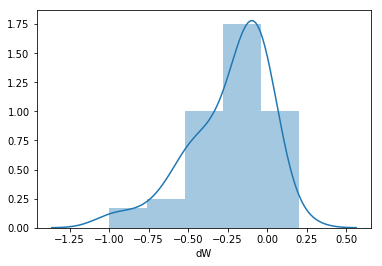

In [270]:
sns.distplot(df['dW'], bins=5)

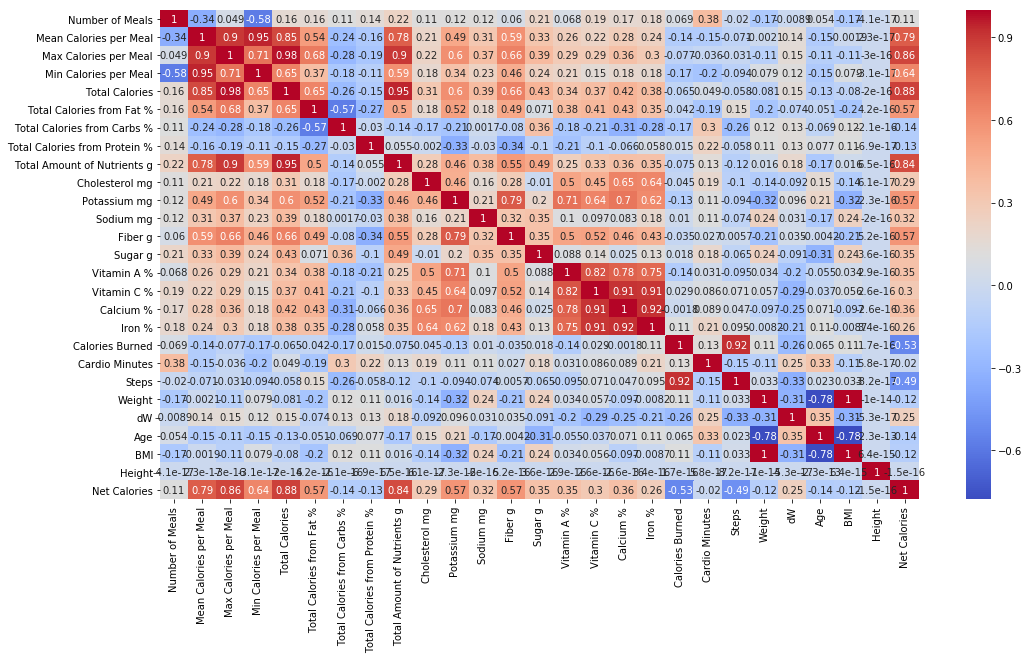

In [271]:
fig, ax = plt.subplots(figsize=(17,9)) # increasing the original size of the heatmap
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)

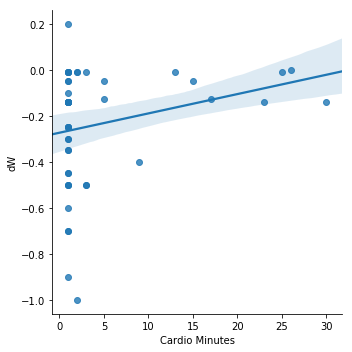

In [272]:
sns.lmplot(y='dW', x='Cardio Minutes', data=df)

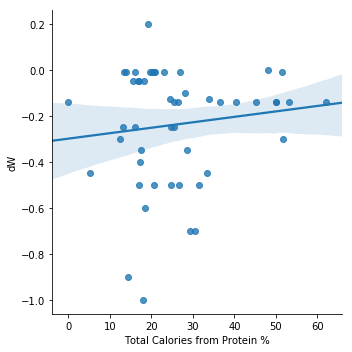

In [273]:
sns.lmplot(y='dW', x='Total Calories from Protein %', data=df)

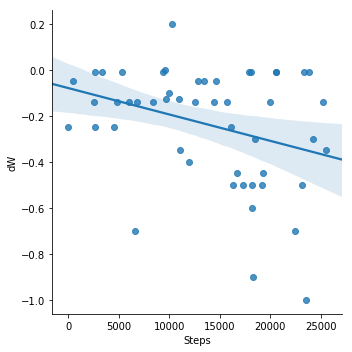

In [274]:
sns.lmplot(y='dW', x='Steps', data=df)

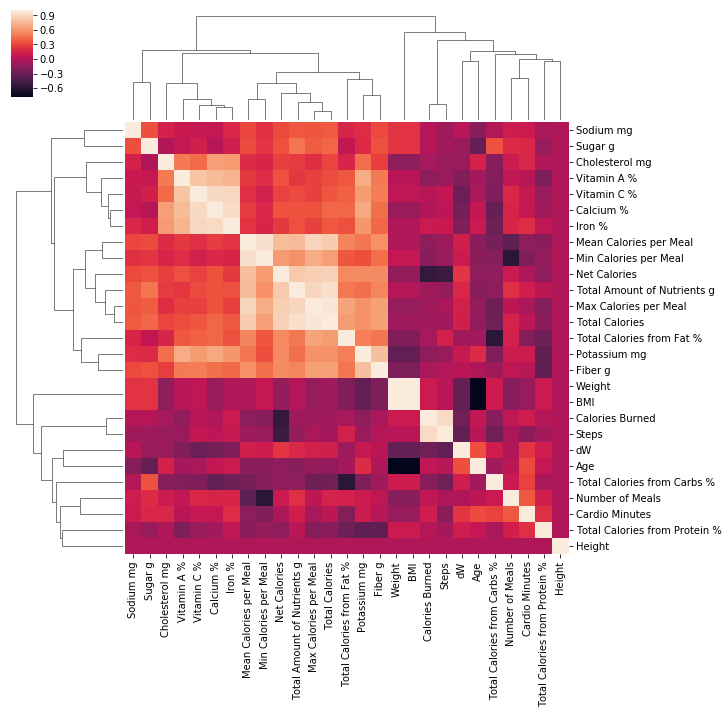

In [275]:
sns.clustermap(df.corr())

## Linear Regression

In [276]:
df.columns

Index(['Number of Meals', 'Mean Calories per Meal', 'Max Calories per Meal',
       'Min Calories per Meal', 'Total Calories', 'Total Calories from Fat %',
       'Total Calories from Carbs %', 'Total Calories from Protein %',
       'Total Amount of Nutrients g', 'Cholesterol mg', 'Potassium mg',
       'Sodium mg', 'Fiber g', 'Sugar g', 'Vitamin A %', 'Vitamin C %',
       'Calcium %', 'Iron %', 'Calories Burned', 'Cardio Minutes',
       'Strength Training', 'Steps', 'Weight', 'dW', 'Age', 'BMI', 'Height',
       'Net Calories'],
      dtype='object')

In [277]:
X = df[['Number of Meals', 'Total Calories', 'Total Calories from Fat %', 'Total Calories from Carbs %', 
          'Total Calories from Protein %','Net Calories', 'Sugar g']]

y = df['dW']

In [278]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Number of Meals,0.025770
Total Calories,-0.000008
Total Calories from Fat %,0.004318
Total Calories from Carbs %,0.014895
Total Calories from Protein %,0.008173
Net Calories,0.000208
Sugar g,-0.008847


In [279]:
predictions = lm.predict(X_test)

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.251348194552
MSE: 0.11936675452
RMSE: 0.345494941381
